In [1]:
%reset -f

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2
import numpy as np
import time
import random
def print_np(x):
    print ("Type is %s" % (type(x)))
    print ("Shape is %s" % (x.shape,))
#     print ("Values are: \n%s" % (x))

In [3]:
import os
import sys
sys.path.append('../')

In [4]:
from model import FreeFlyer
from constraints import FreeFlyerConstraints
from cost import FreeFlyerCost
from scipy.integrate import solve_ivp
from matplotlib.patches import Ellipse
from utils.utils_alg import get_neighbor_vec,get_K_discrete
# from utils.utils_plot import plot_traj,plot_traj_set,plot_state_input
from utils.utils_plot import plot_ellipse_2D,plot_ellipse_3D,data_for_cylinder_along_z

# from trajopt_tmp import trajopt
from trajopt import trajopt
from funlopt import funlopt
from Lipschitz import Lipschitz
from Scaling import TrajectoryScaling

from utils.utils_alg import get_sample_eta_w,propagate_model
import cvxpy as cvx
from scipy.integrate import solve_ivp
from utils.utils_alg import forward_full_with_K,get_sample_trajectory

(CVXPY) Nov 15 12:40:01 PM: Encountered unexpected exception importing solver SCS:
ImportError("dlopen(/opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so, 0x0002): Library not loaded: @rpath/liblapack.3.dylib\n  Referenced from: <F9700F1C-290B-3DF3-8D09-CFDF44BAE051> /opt/anaconda3/envs/py309/lib/python3.9/site-packages/_scs_direct.cpython-39-darwin.so\n  Reason: tried: '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/lib/python3.9/site-packages/../../liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/opt/anaconda3/envs/py309/bin/../lib/liblapack.3.dylib' (no such file), '/usr/local/lib/liblapack.3.dylib' (no such file), '/usr/lib/liblapack.3.dylib' (no such file, not in dyld cache)")


In [5]:
N = 15
tf = 200
delT = tf/N

In [6]:
def get_H_obs(rx,ry) :
    return np.diag([1/rx,1/ry])
# obstacle
c_list = []
H_list = []
c1 = [0.5,1.2]
H1 = get_H_obs(0.8,0.8)
c_list.append(c1)
H_list.append(H1)
c2 = [2.5,2.0]
H2 = get_H_obs(0.8,0.8)
c_list.append(c2)
H_list.append(H2)
idx = 0
Xo1,Yo1,Zo1 = data_for_cylinder_along_z(c_list[idx][0],c_list[idx][1],1/H_list[idx][0,0],1/H_list[idx][1,1],3)
idx = 1
Xo2,Yo2,Zo2 = data_for_cylinder_along_z(c_list[idx][0],c_list[idx][1],1/H_list[idx][0,0],1/H_list[idx][1,1],3)

In [7]:
myModel = FreeFlyer.freeflyer('freeflyer','numeric_central')
ix = myModel.ix
iu = myModel.iu
iw = myModel.iw
iq = myModel.iq
ip = myModel.ip

C = myModel.C
D = myModel.D
E = myModel.E
G = myModel.G

myCost = FreeFlyerCost.freeflyer('Hello',ix,iu,N)
myConst = FreeFlyerConstraints.freeflyer('Hello',ix,iu)
myConst.set_obstacle(c_list,H_list)

In [8]:
xi = np.array([0,0,3, 0,0,0, -np.deg2rad(30),np.deg2rad(25),np.deg2rad(5), 0,0,0])
xf = np.array([3,3,0, 0,0,0, 0,0,0, 0,0,0])

In [9]:
Qini = np.diag([0.2**2,0.2**2,0.2**2, \
                0.02**2,0.02**2,0.02**2, \
                np.deg2rad(5)**2,np.deg2rad(5)**2,np.deg2rad(5)**2, \
                np.deg2rad(0.1)**2,np.deg2rad(0.1)**2,np.deg2rad(0.1)**2])
Qf = Qini

x0 = np.zeros((N+1,ix))
for i in range(N+1) :
    x0[i] = (N-i)/N * xi + i/N * xf
# u0 = np.zeros((N+1,iu))
x0[:,3] = 1e-6
x0[:,4] = 1e-6
x0[:,5] = 1e-6
x0[:,9] = 1e-6
x0[:,10] = 1e-6
x0[:,11] = 1e-6
u0 = 1e-12*np.ones((N+1,iu))

In [10]:
import pypickle
name = "freeflyer_history"
filepath = '/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/'+name+'.pkl'
history = pypickle.load(filepath)

[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/freeflyer_history.pkl]


In [11]:
name = "freeflyer_initial_guess"
filepath = '/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/'+name+'.pkl'
initial = pypickle.load(filepath)

[pypickle] Pickle file loaded: [/Users/taewankim/Documents/Code/ForPapers/2022_IJRNC_joint_synthesis/data/freeflyer_initial_guess.pkl]


# computational time

In [12]:
time_derivs = []
time_trajopt = []
time_funlopt = []
time_lipschitz = []
for his in history[1:] :
    time_derivs.append(his['t_derivs'])
    time_trajopt.append(his['t_trajopt'])
    time_funlopt.append(his['t_funlopt'])
    time_lipschitz.append(his['t_Lipschitz'])
def mean_list(l) :
    return sum(l)/len(l)
mean_derivs = mean_list(time_derivs)
mean_trajopt = mean_list(time_trajopt)
mean_funlopt = mean_list(time_funlopt)
mean_lipschitz = mean_list(time_lipschitz)
print("mean_derivs",mean_derivs)
print("mean_trajopt",mean_trajopt)
print("mean_funlopt",mean_funlopt)
print("mean_lipschitz",mean_lipschitz)

mean_derivs 0.07282061576843261
mean_trajopt 0.02430691719055176
mean_funlopt 10.071954345703125
mean_lipschitz 2.697501611709595


In [13]:
from utils.utils_alg import forward_full_with_K,get_sample_trajectory
import scipy

In [14]:
xbar = history[-1]['x']
ubar = history[-1]['u']
Qbar = history[-1]['Q']
Ybar = history[-1]['Y']
Kbar = history[-1]['K']
gammabar = history[-1]['gamma']

x0 = initial['x0']
Q0 = initial['Q0']
tnom = np.array(range(N+1))*delT

In [15]:
x0_sample = []
num_sample = 300
for i in range(num_sample) :
    z = np.random.randn(ix)
    z = z / np.linalg.norm(z)
    x_s = xbar[0] + scipy.linalg.sqrtm(Qbar[0])@z
    x0_sample.append(x_s)

In [16]:
tsam,xsam,usam,wsam,xsamp = get_sample_trajectory(xi,x0_sample,xbar,ubar,Qbar,Ybar,myModel,N,ix,iu,iw,delT,
                                            flag_noise=True)

In [17]:
import seaborn as sns
import matplotlib.font_manager as font_manager
fS = 15
csfont = {'fontsize':fS,'fontname':'Times New Roman'}
font = font_manager.FontProperties(family='Times New Roman',
                                   style='normal', size=fS)

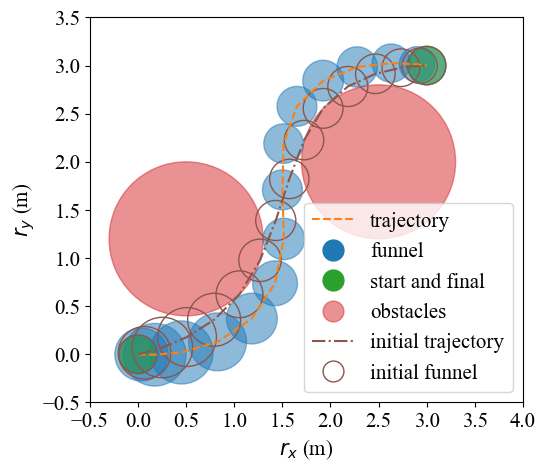

In [18]:
fig = plt.figure(1,figsize=(6,5))
ax = fig.add_subplot(111)
for ce,H in zip(c_list,H_list) :
        rx = 1/H[0,0]
        ry = 1/H[1,1]
        circle1 = Ellipse((ce[0],ce[1]),rx*2,ry*2,color='tab:red',alpha=0.5,fill=True)
        ax.add_patch(circle1)
for i in range(N+1) :
    plot_ellipse_2D(ax,Qbar[i],xbar[i])
plot_ellipse_2D(ax,Qini,xi,color='tab:green')
plot_ellipse_2D(ax,Qf,xf,color='tab:green')
ax.set_xlabel('$r_x$ (m)',**csfont)
ax.set_ylabel('$r_y$ (m)',**csfont)
ax.plot(xbar[:,0],xbar[:,1],'--',color='tab:orange')
ax.plot(x0[:,0],x0[:,1],'-.',color='tab:brown')
for i in range(N+1) :
    plot_ellipse_2D(ax,Q0[i],x0[i],color='tab:brown',fill=False,alpha=1.0)
plt.plot(1e3,1e3,'--',color='tab:orange',label="trajectory")
plt.plot(1e3,1e3,'o',markersize=15,color='tab:blue',label="funnel") 
plt.plot(1e3,1e3,'o',markersize=15,color='tab:green',label="start and final") 
plt.plot(1e3,1e3,'o',markersize=15,alpha=0.5,color='tab:red',label="obstacles") 
plt.plot(1e3,1e3,'-.',color='tab:brown',label="initial trajectory")
plt.plot(1e3,1e3,'o',markersize=15,fillstyle='none',linewidth=4,color='tab:brown',label="initial funnel") 
plt.legend(prop=font)
plt.axis([-0.5, 4.0, -0.5, 3.5])
plt.gca().set_aspect('equal', adjustable='box')
plt.xticks(**csfont)
plt.yticks(**csfont)
plt.savefig("../images/freeflyer/freeflyer_traj_2D_result.pdf",bbox_inches='tight')

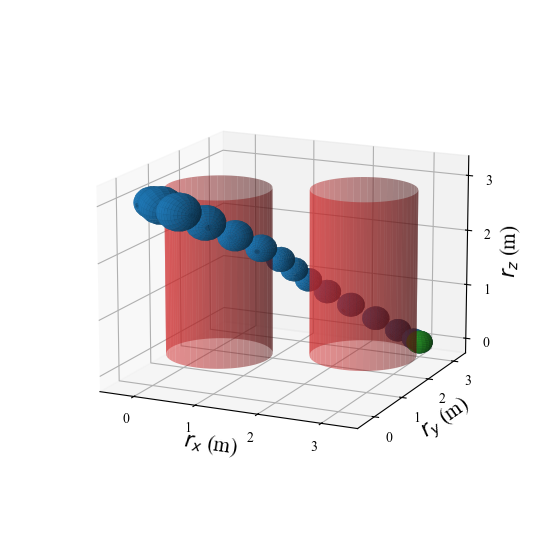

In [21]:
fig = plt.figure(1,figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Xo1, Yo1, Zo1, alpha=0.5,color='tab:red')
ax.plot_surface(Xo2, Yo2, Zo2, alpha=0.5,color='tab:red')
ax.plot(xbar[:, 0],xbar[:, 1], xbar[:, 2],'--',color='tab:blue')
for i in range(N+1) :
    plot_ellipse_3D(ax,Qbar[i],xbar[i])
plot_ellipse_3D(ax,Qini,xi,color='tab:green')
plot_ellipse_3D(ax,Qf,xf,color='tab:green')

ax.view_init(15, -65)
fS = 15
ax.set_xticks([0,1,2,3])
ax.set_yticks([0,1,2,3])
ax.set_zticks([0,1,2,3])
ax.set_xlabel('$r_x$ (m)',**csfont)
ax.set_ylabel('$r_y$ (m)',**csfont)
ax.set_zlabel('$r_z$ (m)',**csfont)
ax.set_box_aspect(aspect=None, zoom=0.8)
plt.rcParams['font.family'] = ['Times New Roman']
# plt.gca().set_aspect('equal', adjustable='box')
plt.savefig("../images/freeflyer/freeflyer_traj_3D_result.pdf",bbox_inches='tight')
# plt.savefig("../images/freeflyer/freeflyer_traj_3D_result.pdf")

In [22]:
# def get_input_margin_by_funnel(Q,K) :
#     N = len(Q) - 1
#     R1 = []
#     for i in range(N+1) :
#         R1.append(K[i]@Q[i]@K[i].T)
#     a1 = np.array([1,0])
#     a2 = np.array([0,1])
#     vfunl1 = []
#     wfunl1 = []
#     for i in range(N+1) :
#         vfunl1.append(np.sqrt(a1.T@R1[i]@a1))
#         wfunl1.append(np.sqrt(a2.T@R1[i]@a2))
#     vfunl1 = np.array(vfunl1)
#     wfunl1 = np.array(wfunl1)
#     return vfunl1,wfunl1

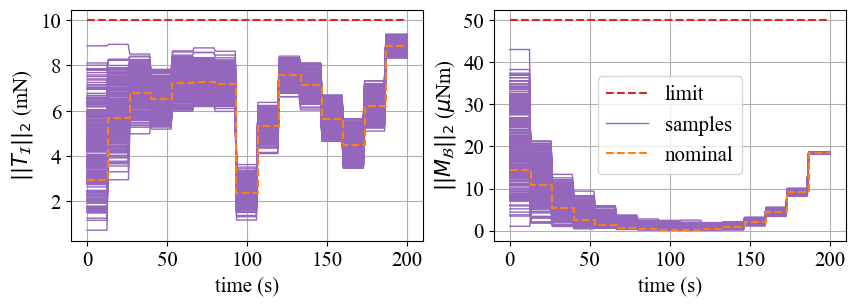

In [31]:
fig = plt.figure(3,figsize=(10,3))
ax = fig.add_subplot(121)
ax.set_xlabel('time (s)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Tmax*1e3,'--',color='tab:red')
for t_e,usam_e in zip(tsam,usam) :
    Tnorm = np.linalg.norm(usam_e[:,0:3],axis=1)
    Mnorm = np.linalg.norm(usam_e[:,3:],axis=1)
    ax.plot(t_e, Tnorm*1e3,'-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
ax.set_xlabel('time (s)',**csfont)
ax.set_ylabel('$||T_{\mathcal{I}}||_2$ (mN)',**csfont)
Tnorm = np.linalg.norm(ubar[:,0:3],axis=1)
ax.step(tnom, [*Tnorm[:N]*1e3,Tnorm[N-1]*1e3],'--',
        color='tab:orange',where='post',label='$M_x$')
plt.grid(True)
plt.xticks(**csfont)
plt.yticks(**csfont)
ax = fig.add_subplot(122)
ax.set_xlabel('time (s)',**csfont)
ax.set_ylabel('$||M_{\mathcal{B}}||_2$ ($\mu$Nm)',**csfont)
ax.plot(tnom, tnom*0 + myConst.Mmax*1e6,'--',color='tab:red',label='limit')
for t_e,usam_e in zip(tsam,usam) :
    Mnorm = np.linalg.norm(usam_e[:,3:],axis=1)
    ax.plot(t_e, Mnorm*1e6,'-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple')
ax.plot(t_e, Mnorm*1e6,'-',markersize=3.0, linewidth=1.0,alpha=1.0,color='tab:purple',label='samples')
Mnorm = np.linalg.norm(ubar[:,3:],axis=1)
ax.step(tnom, [*Mnorm[:N]*1e6,Mnorm[N-1]*1e6],'--',
        color='tab:orange',where='post',label='nominal')
ax.legend(prop=font)
plt.grid(True)
plt.xticks(**csfont)
plt.yticks(**csfont)
plt.savefig("../images/freeflyer/freeflyer_input_result.pdf",bbox_inches='tight')

In [27]:
def get_radii_list(xsamp,xbar,Qbar) :
    radii_list = []
    for x in xsamp :
        radii = np.zeros(N+1)
        for i in range(N+1) :
            radii[i] = (x[i]-xbar[i]).T@np.linalg.inv(Qbar[i])@(x[i]-xbar[i])
            if radii[i] > 1 + 1e-8 :
                print("invariance violation",radii[i])
        radii_list.append(radii)
    return radii_list
radii_list = get_radii_list(xsamp,xbar,Qbar)

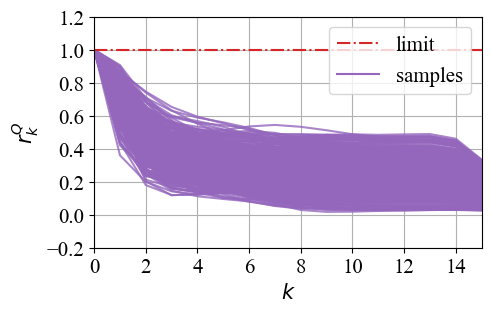

In [30]:
fS = 20
idx_plot = [i for i in range(N+1)]
fig, ax = plt.subplots(figsize=[5, 3])
for radii in radii_list :
    ax.plot(idx_plot,radii,'-',color='tab:purple',alpha=0.8)
ax.plot(idx_plot,radii*0+1,'-.',color='tab:red',alpha=1.0,label='limit')
plt.xlabel('$k$', **csfont)
plt.ylabel('$r^Q_k$', **csfont)
plt.grid(True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
if idx != 2 :
    plt.axis([0,15,-0.2,1.2])
else :
    plt.axis([0,15,-0.2,2.0])
plt.plot(1e3,1e3,'-',color='tab:purple',alpha=1.0,label='samples')
plt.legend(prop=font)
# if idx != 2 :
plt.grid(True)
plt.xticks(**csfont)
plt.yticks(**csfont)
plt.savefig("../images/freeflyer/freeflyer_invariance.pdf",bbox_inches='tight')